In [267]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import math
from typing import Literal

In [268]:
# 数据集路径及文件名
file_path = './dataset/'
file_name_A = 'cityA_groundtruthdata.csv.gz'
file_name_B = 'cityB_challengedata.csv.gz'
file_name_C = 'cityC_challengedata.csv.gz'
file_name_D = 'cityD_challengedata.csv.gz'

In [269]:
# 读取数据集并转换为numpy数组格式
traj_A = pd.read_csv(file_path + file_name_A, compression='gzip').to_numpy()
traj_B = pd.read_csv(file_path + file_name_B, compression='gzip').to_numpy()
traj_C = pd.read_csv(file_path + file_name_C, compression='gzip').to_numpy()
traj_D = pd.read_csv(file_path + file_name_D, compression='gzip').to_numpy()

# Distance Statics

In [270]:
# 函数：计算欧式距离
def Euclidean_Distance(point1, point2):
    """
    计算二维空间中两个点之间的欧式距离。
    
    参数
    point1 (tuple): 第一个点的坐标，格式为 (x1, y1);
    point2 (tuple): 第二个点的坐标，格式为 (x2, y2)
    
    返回值:
    float: 两个点之间的欧式距离
    """
    x1, y1 = point1
    x2, y2 = point2
    distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return distance

In [271]:
# 函数：剔除不需要的数据点
def mask_to_predict(ref_arr, *arrs, rm_A=False):
    """
    rm_A = True  时剔除61-75天的数据点，ref_list应为day的numpy数组
    rm_A = False 时剔除待预测的数据点，ref_list应为x或y的numpy数组
    返回所有需要剔除的数组，包括ref_list
    """
    # 剔除条件
    if rm_A is True:
        mask = ref_arr < 60
    else:
        mask = ref_arr <= 200
    # 初始化
    masked_arrs = []
    # 剔除
    masked_ref_list = ref_arr[mask]
    masked_arrs.append(masked_ref_list)
    for arr in arrs:
        masked_arr = arr[mask]
        masked_arrs.append(masked_arr)
    
    return masked_arrs

### Distance/User

In [272]:
# 函数：计算城市中每用户的总距离
def dis_peruser(traj, rm_A=False):
    """
    计算每个用户的轨迹总距离：
    参数: numpy数组(uid, day, timeslot, x, y),rm_A=Ture时表示剔除61-75天的数据
    返回: numpy数组(distance)
    """
    
    # 提取所需数据
    uids, days, x_values, y_values = traj[:, 0], traj[:, 1], traj[:, 3], traj[:, 4]

    # 剔除待预测点
    if rm_A is False:
        x_values, y_values, uids = mask_to_predict(x_values, y_values, uids)
    else:
        days, x_values, y_values, uids = mask_to_predict(days, x_values, y_values, uids, rm_A=rm_A)

    # 初始化
    max_uids = int(np.max(uids)) + 1
    dis_per_user = np.zeros(max_uids)
    dis = 0

     # 按用户统计距离
    for i in range(len(x_values)):
        if (i != 0) and (uids[i] != uids[i-1]):
            dis_per_user[uids[i-1]] = dis
            dis = 0
            continue
        dis += Euclidean_Distance((x_values[i], y_values[i]),(x_values[i-1], y_values[i-1]))
    
    return dis_per_user

In [279]:
# 函数：绘制城市内每用户总距离分布的柱状图
def plot_bar_dis_pu(dis_pu, city: Literal['A','B','C','D'], bin_stamp=100, total_days=75):
    """绘制平均轨迹距离用户数分布的柱状图，频数及距离均归一化"""
    # 柱状图参数
    counts, bins = np.histogram(dis_pu, bins=bin_stamp)
    
    # 归一化
    normalized_counts = counts / np.sum(counts)
    total_dis = bins[-1]
    bins[:] = bins[:] / total_dis

    # 绘制柱状图
    plt.figure()
    plt.bar(bins[:-1], normalized_counts, width=np.diff(bins), edgecolor='black', alpha=0.7)
    plt.title('Distribution of distance during ' + str(total_days) + ' days for city ' + city)
    plt.xlabel('Distance(normalized, total=' + str(total_dis) + ')' )
    plt.ylabel('#users(normalized, total=' + str(len(dis_pu)) + ')')
    plt.show()

In [274]:
# 计算各城市的每用户总距离
# 1-75天
dis_pu_A = dis_peruser(traj_A)
# dis_pu_B = dis_per_user(traj_B)
# dis_pu_C = dis_per_user(traj_C)
# dis_pu_D = dis_per_user(traj_D)

# 1-60天
dis_pu_A_rm = dis_peruser(traj_A, rm_A=True)
dis_pu_B_rm = dis_peruser(traj_B, rm_A=True)
dis_pu_C_rm = dis_peruser(traj_C, rm_A=True)
dis_pu_D_rm = dis_peruser(traj_D, rm_A=True)

[5038.479904877441, 4347.384041324108, 3748.8194450819983, 5733.116299407202]


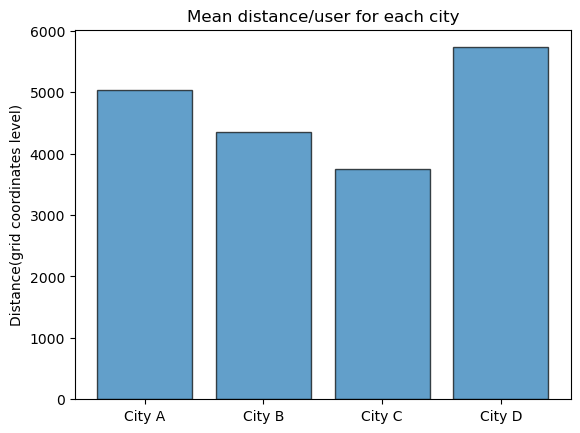

In [275]:
# 计算1-60天各城市平均每用户的总距离并绘制柱状图
A = np.mean(dis_pu_A_rm)
B = np.mean(dis_pu_B_rm)
C = np.mean(dis_pu_C_rm)
D = np.mean(dis_pu_D_rm)

mean_dis_pu = [A, B, C, D]
print(mean_dis_pu)

# 绘制柱状图
x_label = ['City A', 'City B', 'City C', 'City D']
plt.bar(x_label, mean_dis_pu, edgecolor='black', alpha=0.7)
plt.title('Mean distance/user for each city')
plt.ylabel('Distance(grid coordinates level)')
plt.show()

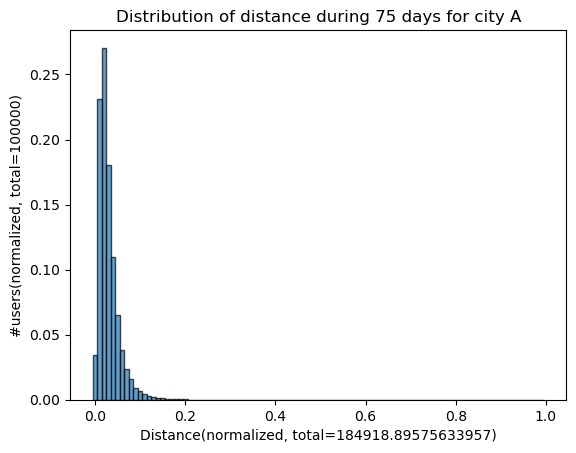

In [260]:
# 绘制1-75天城市A的每用户总距离分布图
plot_bar_dis_pu(dis_pu_A, city='A')

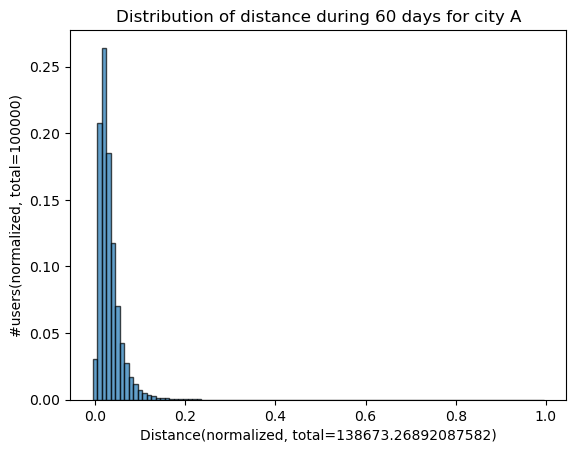

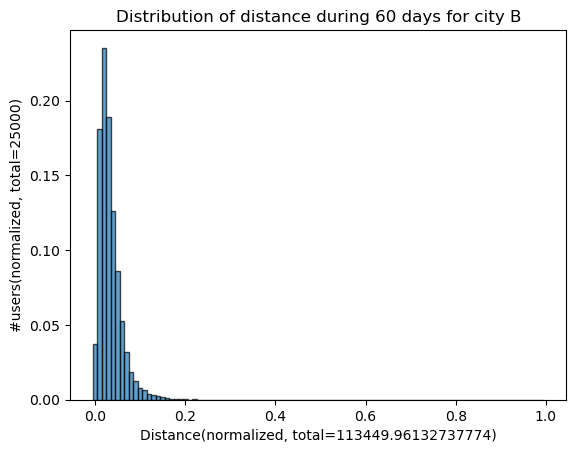

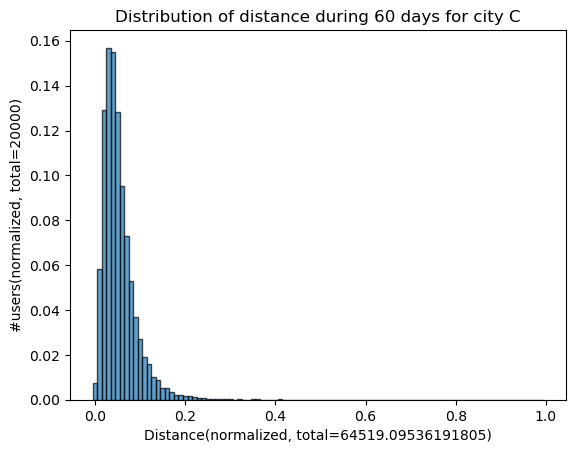

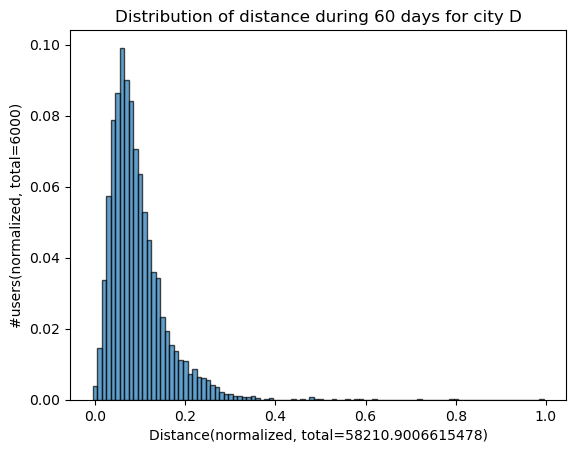

In [261]:
# 绘制1-60天各城市的每用户总距离分布图
plot_bar_dis_pu(dis_pu_A_rm, city='A', total_days=60)
plot_bar_dis_pu(dis_pu_B_rm, city='B', total_days=60)
plot_bar_dis_pu(dis_pu_C_rm, city='C', total_days=60)
plot_bar_dis_pu(dis_pu_D_rm, city='D', total_days=60)

### Distance/(Day*User)

In [276]:
# 函数：计算城市内每用户每天的总距离
def dis_peruser_perday(traj, rm_A=False): 
    """
    计算每个用户每天的轨迹总距离
    输入：numpy数组(uid, day, timeslot, x, y)
    输出：numpy数组(distance), size=(#user, #day)
    """
    # 提取数据
    uids, days, x_values, y_values = traj[:, 0], traj[:, 1], traj[:, 3], traj[:, 4]

    # 剔除待预测点
    if rm_A is False:
        x_values, uids, days, y_values = mask_to_predict(x_values, uids, days, y_values)
    else:
        days, uids, x_values, y_values = mask_to_predict(days, uids, x_values, y_values)

    # 初始化
    num_users = np.max(uids) + 1
    num_days = np.max(days) + 1
    dis_pp = np.zeros((num_users, num_days))
    dis = 0
    # 统计每个用户每天的平均距离
    for i in range(len(x_values)):
        if (days[i] != days[i-1]) or (uids[i] != uids[i-1]):
            if i != 0:
                dis_pp[uids[i-1], days[i-1]] = dis
            dis = 0
            continue
        dis += Euclidean_Distance((x_values[i], y_values[i]),(x_values[i-1], y_values[i-1]))
    
    return dis_pp.flatten()

In [213]:
# 函数：绘制城市内每用户每日总距离分布的柱状图
def plot_distribution_dis_pp(dis_pp, city: Literal['A','B','C','D'], bin_stamp=100):
    """绘制城市内每用户每日总距离分布的柱状图，用户数及距离区间均归一化"""

    # 柱状图参数
    counts, bins = np.histogram(dis_pp, bins=bin_stamp)

    # 归一化参数
    total_dis = bins[-1]
    normalized_counts = counts / np.sum(counts)    # 归一化频数
    bins[:] = bins[:] / bins[-1]

    # 绘制频率归一化的柱状图
    plt.figure()
    plt.bar(bins[:-1], normalized_counts, width=np.diff(bins), edgecolor='black', alpha=0.7)
    plt.title('Distribution of distance per day for ' + city)   #标题
    plt.xlabel('Distance(normalized, total=' + str(total_dis) + ')' )   #x轴标签
    plt.ylabel('#users(normalized, total=' + str(len(dis_pp)) + ')')    #y轴标签
    plt.show()

In [278]:
# 计算各城市每用户每天的总距离
# 1-75天
dis_pp_A = dis_peruser_perday(traj_A)
# dis_pp_B = dis_peruser_perday(traj_B)
# dis_pp_C = dis_peruser_perday(traj_C)
# dis_pp_D = dis_peruser_perday(traj_D)

# 1-60天
dis_pp_A_rm = dis_peruser_perday(traj_A, rm_A=True)
dis_pp_B_rm = dis_peruser_perday(traj_B, rm_A=True)
dis_pp_C_rm = dis_peruser_perday(traj_C, rm_A=True)
dis_pp_D_rm = dis_peruser_perday(traj_D, rm_A=True)


[80.34989776498163, 66.54434839594113, 56.16283016004674, 82.58275593558204]


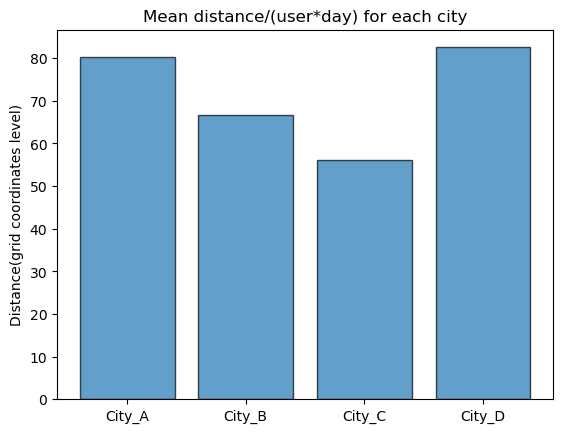

In [208]:
# 计算各城市平均每用户每天的总距离并绘制柱状图
A = np.mean(dis_pp_A_rm)
B = np.mean(dis_pp_B_rm)
C = np.mean(dis_pp_C_rm)
D = np.mean(dis_pp_D_rm)

mean_dis_pp = [A, B, C, D]
print(mean_dis_pp)

# 绘制柱状图
x_label = ['City_A', 'City_B', 'City_C', 'City_D']
plt.bar(x_label, mean_dis_pp, edgecolor='black', alpha=0.7)
plt.title('Mean distance/(user*day) for each city')
plt.ylabel('Distance(grid coordinates level)')
plt.show()

In [ ]:
# 绘制1-75天城市A每用户每日总距离分布的柱状图
plot_distribution_dis_pp(dis_pp_A, 'City A')

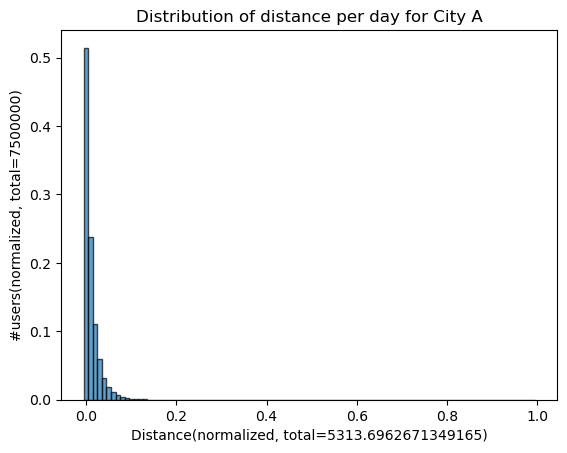

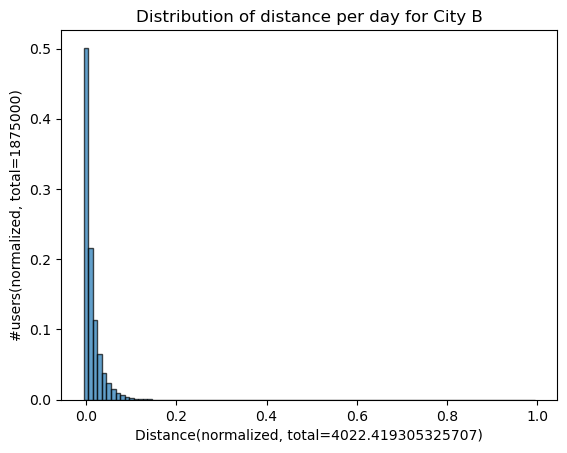

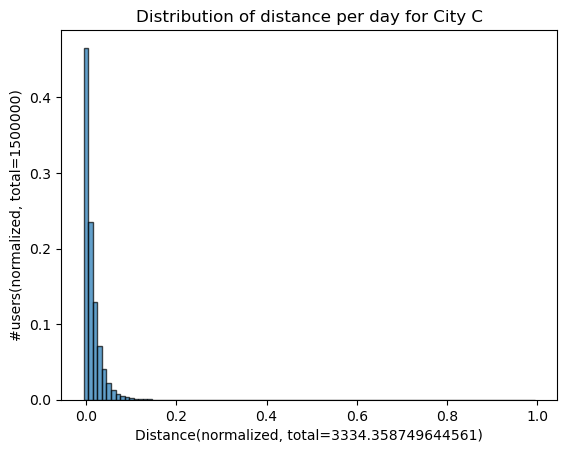

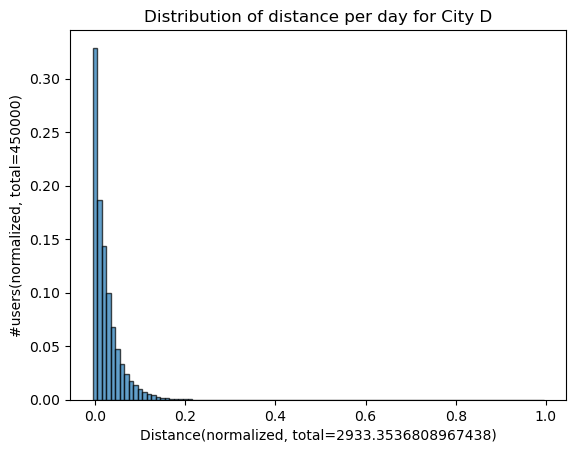

In [214]:
# 绘制1-60天各城市每用户每日总距离分布的柱状图
plot_distribution_dis_pp(dis_pp_A_rm, 'City A')
plot_distribution_dis_pp(dis_pp_B_rm, 'City B')
plot_distribution_dis_pp(dis_pp_C_rm, 'City C')
plot_distribution_dis_pp(dis_pp_D_rm, 'City D')

# Temporal Statics

In [91]:
traj_A[:200]

array([[  0,   0,   1,  79,  86],
       [  0,   0,   2,  79,  86],
       [  0,   0,   8,  77,  86],
       [  0,   0,   9,  77,  86],
       [  0,   0,  19,  81,  89],
       [  0,   0,  20,  82,  88],
       [  0,   0,  21,  81,  89],
       [  0,   0,  22,  81,  89],
       [  0,   0,  24,  76,  86],
       [  0,   0,  25,  75,  82],
       [  0,   0,  27,  76,  84],
       [  0,   0,  29,  76,  83],
       [  0,   0,  30,  77,  86],
       [  0,   0,  42,  79, 106],
       [  0,   0,  43,  76,  85],
       [  0,   0,  45,  77,  86],
       [  0,   1,  17,  76,  84],
       [  0,   1,  18,  76,  84],
       [  0,   1,  19,  76,  85],
       [  0,   1,  20,  75,  85],
       [  0,   1,  21,  77,  86],
       [  0,   1,  22,  80,  83],
       [  0,   1,  23,  77,  85],
       [  0,   1,  24,  77,  86],
       [  0,   1,  40,  78,  85],
       [  0,   1,  43,  77,  85],
       [  0,   2,  12,  84,  89],
       [  0,   2,  13,  89,  78],
       [  0,   2,  14, 115,  80],
       [  0,  

 - notes that some consecutive datarow do not reveal a spatial move

## User Activity Data Histogram

In [219]:
# 函数：绘制时间轴折线图
def plot_histogram(timeslot_count, 
                   city: Literal['City A', 'City B', 'City C', 'City D'],
                   type: Literal['Data', 'Move']):
    """绘制时间轴折线图"""
    # 绘制折线图
    plt.figure(figsize=(80, 5))
    plt.plot(timeslot_count, linestyle='-', color='blue')

    # 设置坐标轴范围
    plt.xlim(0, len(timeslot_count) - 1)  # 使 x 轴范围覆盖整个数据
    plt.ylim(min(timeslot_count), max(timeslot_count))  # 使 y 轴范围覆盖所有数据点

    # 生成连续的时间序列刻度并设置刻度标签
    x_ticks = np.arange(0, (75 + 1) * 48, 48)  # 每48个timeslot为一天
    x_tick_labels = [f'Day {i}' for i in range(75 + 1)]
    plt.xticks(ticks=x_ticks, labels=x_tick_labels, rotation=30)

    # 标题标签
    plt.title( type + ' Count Histogram for ' + city)
    plt.xlabel('Time (#day)')
    plt.ylabel(type + ' Count')

    # 显示图像
    plt.show()

In [225]:
# 函数：按时间轴统计城市内用户数据的活跃度
def UADH(traj, remove=False):
    """按时间轴统计城市内用户数据的活跃度"""

    # 提取数据
    days = traj[:, 1]
    timeslots = traj[:, 2]
    x_values = traj[:, 3]

    # 剔除待预测点
    if remove is True:
        mask = x_values != 999
        days, timeslots = days[mask], timeslots[mask]

    # 初始化
    num_days = int(np.max(days)) + 1
    timeslot_count = np.zeros((num_days, 48)) # 以二维索引存储对应day和timeslot的次数

    # 统计各时间戳上的数据数
    for day, timeslot in zip(days, timeslots):
        timeslot_count[int(day), int(timeslot)] += 1

    flattened_timeslot_count = timeslot_count.flatten() # 展平为一维数组
    return flattened_timeslot_count


In [226]:
# 按时间轴统计各城市用户数据活跃度
data_count_A = UADH(traj_A)
data_count_B = UADH(traj_B)
data_count_C = UADH(traj_C)
data_count_D = UADH(traj_D)

# 剔除待预测点
data_count_B_rm = UADH(traj_B, remove=True)
data_count_C_rm = UADH(traj_C, remove=True)
data_count_D_rm = UADH(traj_D, remove=True)

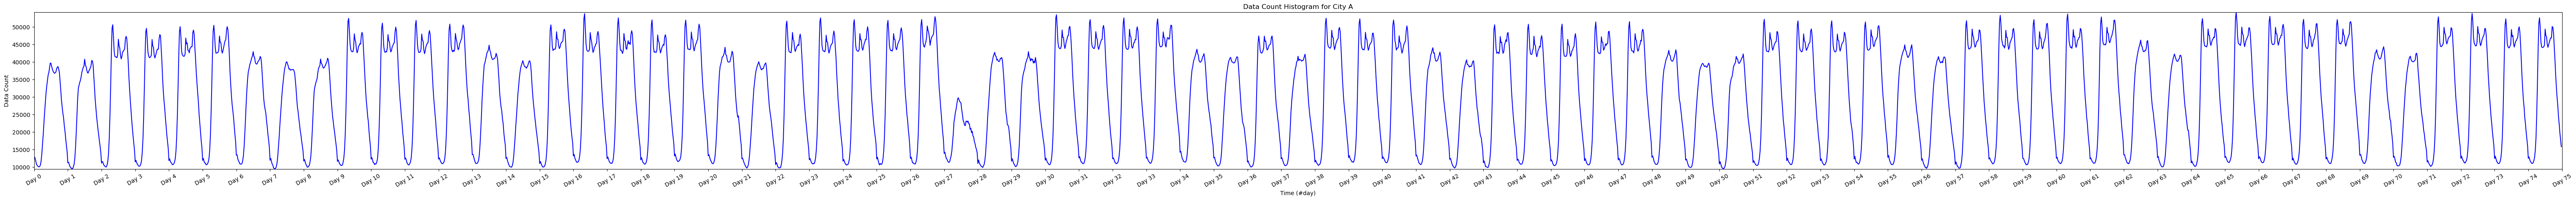

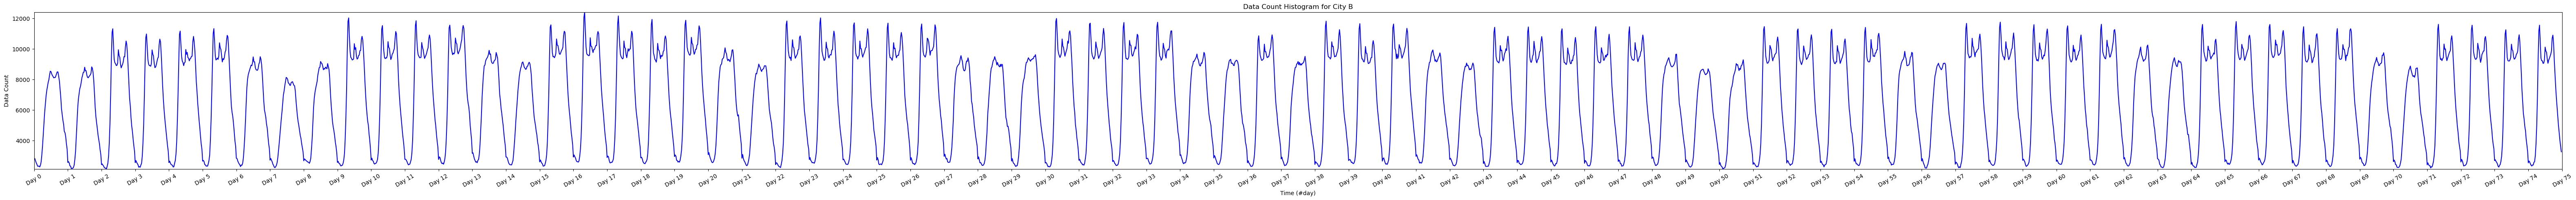

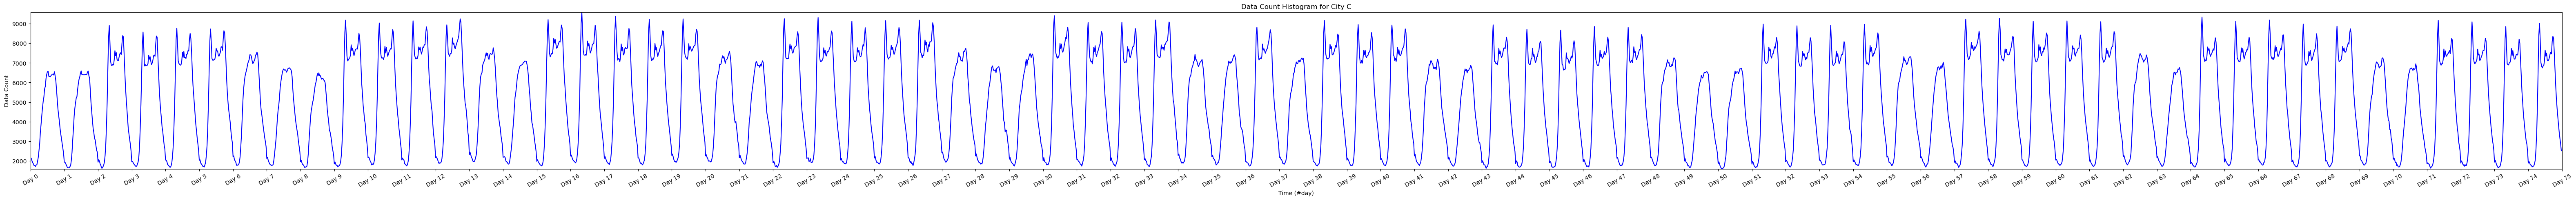

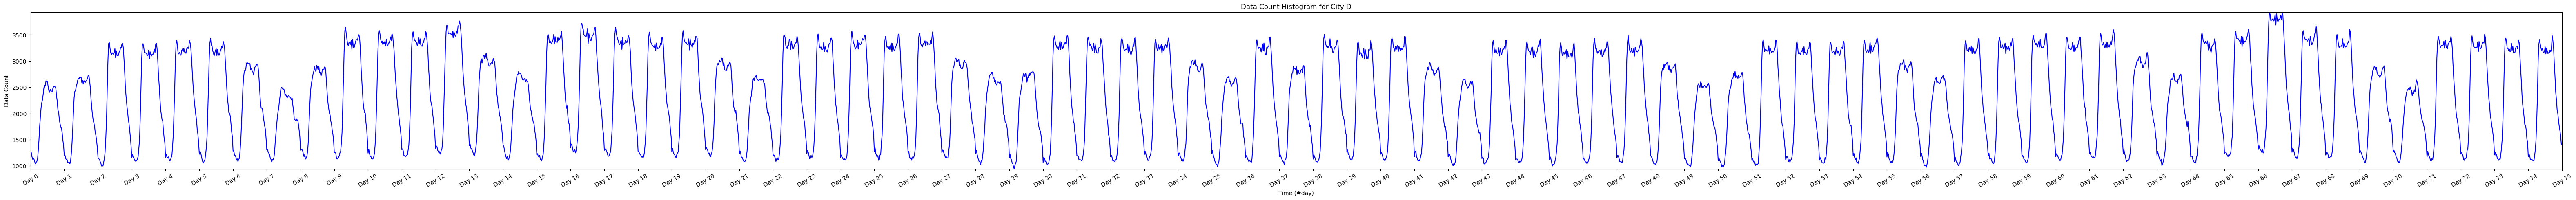

In [227]:
# 绘制各城市用户数据活跃度的时间轴折线图（未剔除待预测点）
plot_histogram(data_count_A, 'City A', 'Data')
plot_histogram(data_count_B, 'City B', 'Data')
plot_histogram(data_count_C, 'City C', 'Data')
plot_histogram(data_count_D, 'City D', 'Data')

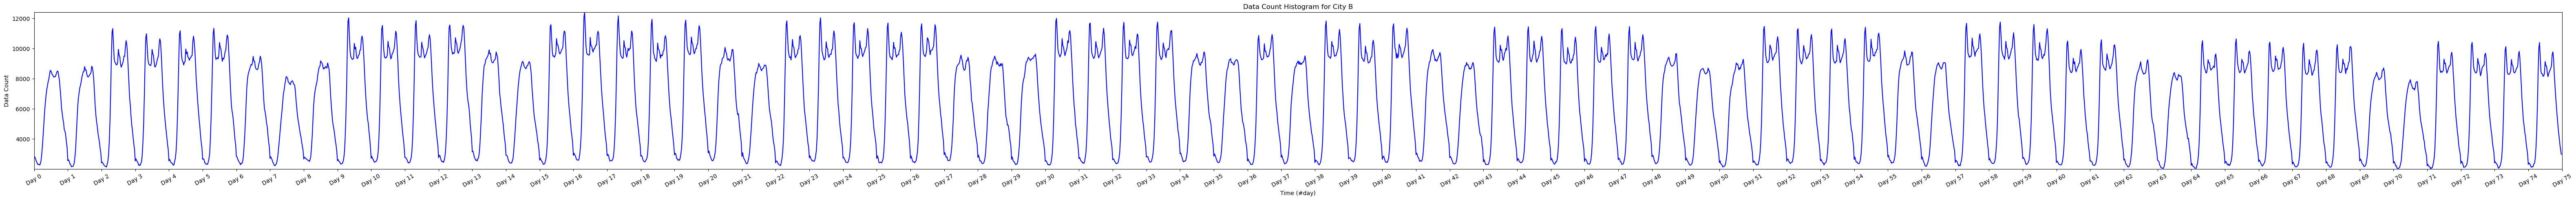

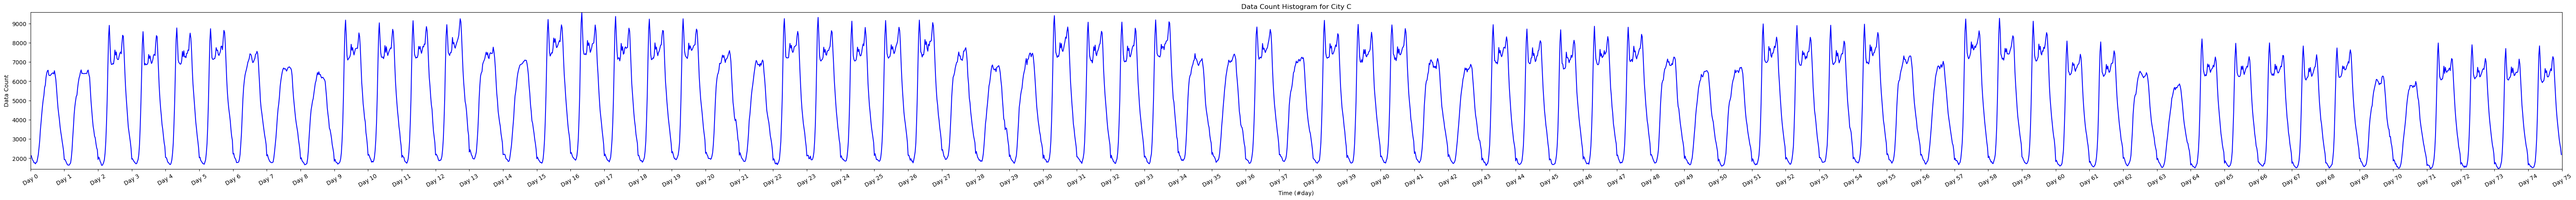

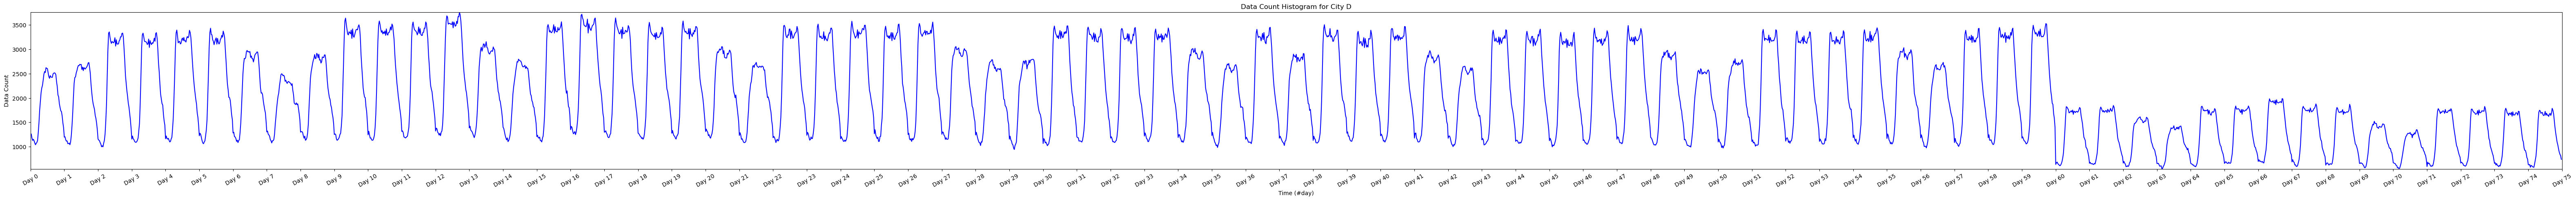

In [229]:
# 绘制各城市用户数据活跃度的时间轴折线图（剔除待预测点）
plot_histogram(data_count_B_rm, 'City B', 'Data')
plot_histogram(data_count_C_rm, 'City C', 'Data')
plot_histogram(data_count_D_rm, 'City D', 'Data')

## User Activity Move Histogram

In [105]:
def UAMH(traj):

    uids = traj[:, 0]
    days = traj[:, 1]
    timeslots = traj[:, 2]
    x_values = traj[:, 3]
    y_values = traj[:, 4]

    num_days = int(np.max(days)) + 1
    num_timeslots = 48

    changed_count = np.zeros((num_days, num_timeslots)) # 初始化统计数组

    for i in range(len(traj)):
        if uids[i] != uids[i-1]:
            continue
        if (x_values[i] == x_values[i-1]) or (y_values[i] == y_values[i-1]):
            continue
        changed_count[days[i], timeslots[i]] += 1

    flattened_timeslot_count = changed_count.flatten()
    return flattened_timeslot_count

In [115]:
move_count_A = UAMH(traj_A)
move_count_B = UAMH(traj_B)
move_count_C = UAMH(traj_C)
move_count_D = UAMH(traj_D)

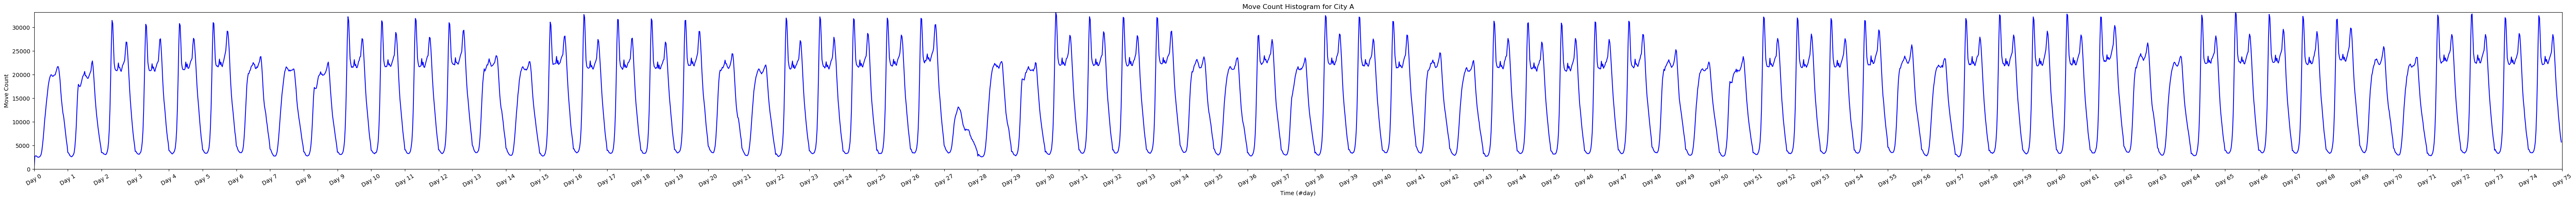

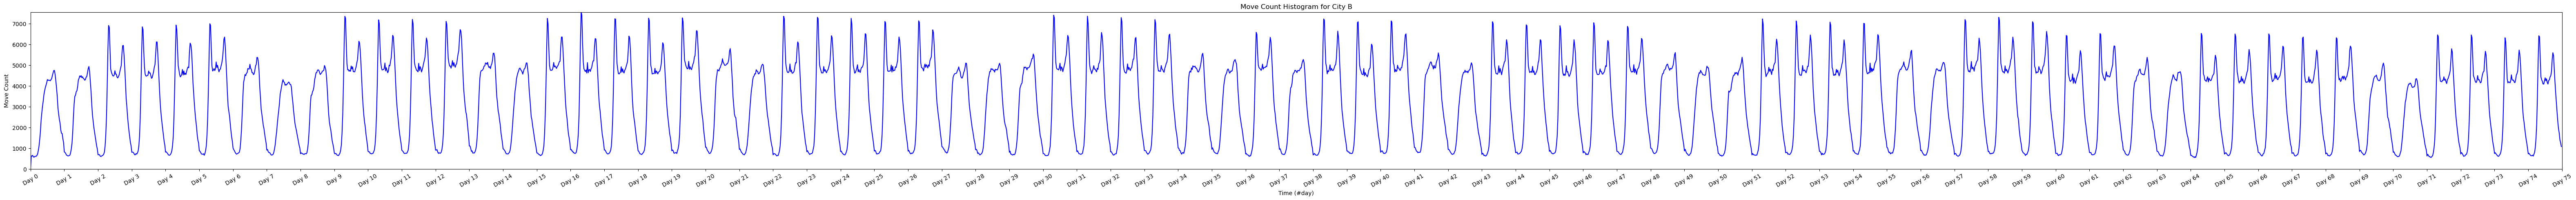

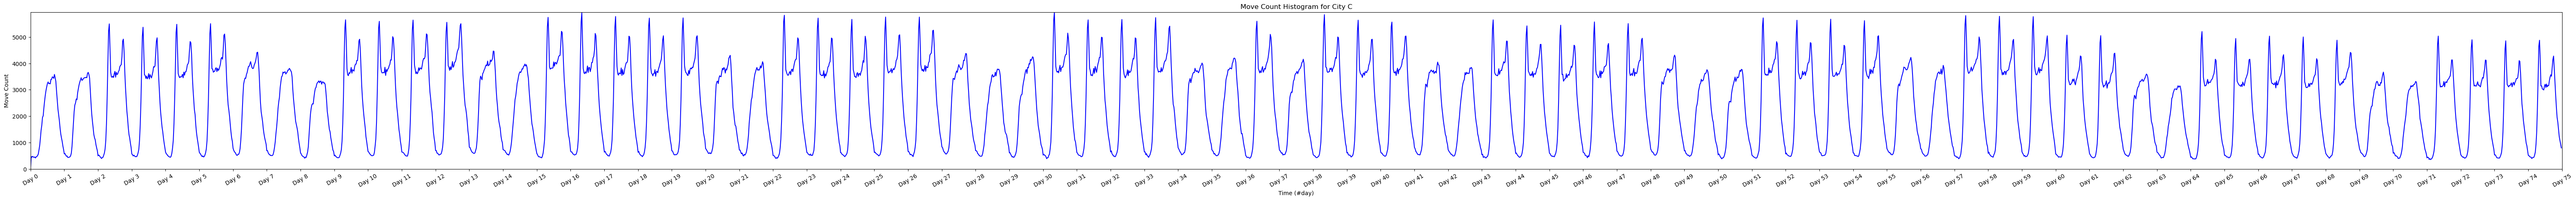

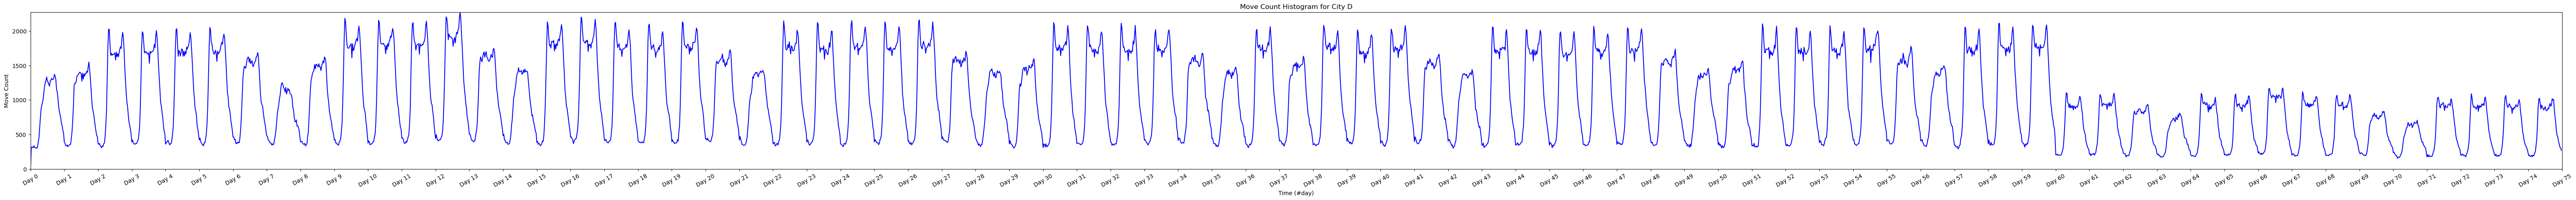

In [116]:
plot_histogram(move_count_A, 'City A', 'Move')
plot_histogram(move_count_B, 'City B', 'Move')
plot_histogram(move_count_C, 'City C', 'Move')
plot_histogram(move_count_D, 'City D', 'Move')

# Spactial Statics

In [224]:
# 函数：绘制不同粒度下轨迹数据空间分布的热力图
def plot_coarse_grained_grid_count(traj,
                                   city: Literal['City A', 'City B', 'City C', 'City D'],
                                   log=False):
    """绘制轨道数据集的不同粒度下的空间分布热力图"""

    # 提取空间信息
    x_values = traj[:, 3]
    y_values = traj[:, 4]
    # 剔除掉值为999的数据
    mask_x, mask_y = x_values != 999, y_values != 999
    x_values, y_values = x_values[mask_x], y_values[mask_y]

    #热力图粒度列表
    grid_sizes = [10, 20, 50]

    fig, axes = plt.subplots(1, len(grid_sizes), figsize=(18, 6))
    for i, grid_size in enumerate(grid_sizes):
        # 计算每个网格的边界
        x_bins = np.linspace(np.min(x_values), np.max(x_values), grid_size)
        y_bins = np.linspace(np.min(y_values), np.max(y_values), grid_size)

        # 统计每个网格中的数据点数量
        heatmap, _, _ = np.histogram2d(x_values, y_values, bins=[x_bins, y_bins])
        if log is True:
            heatmap = np.log1p(heatmap)

        # 绘制热力图
        im = axes[i].imshow(heatmap.T, origin='lower', cmap='Blues', interpolation='nearest')

        # 添加标题
        axes[i].set_title(f'Grid Size: {grid_size}x{grid_size} for ' + city)
        axes[i].set_xlabel('X')
        axes[i].set_ylabel('Y')

        # 添加颜色条
        plt.colorbar(im, ax=axes[i])

    # 调整布局
    plt.tight_layout()
    plt.show()

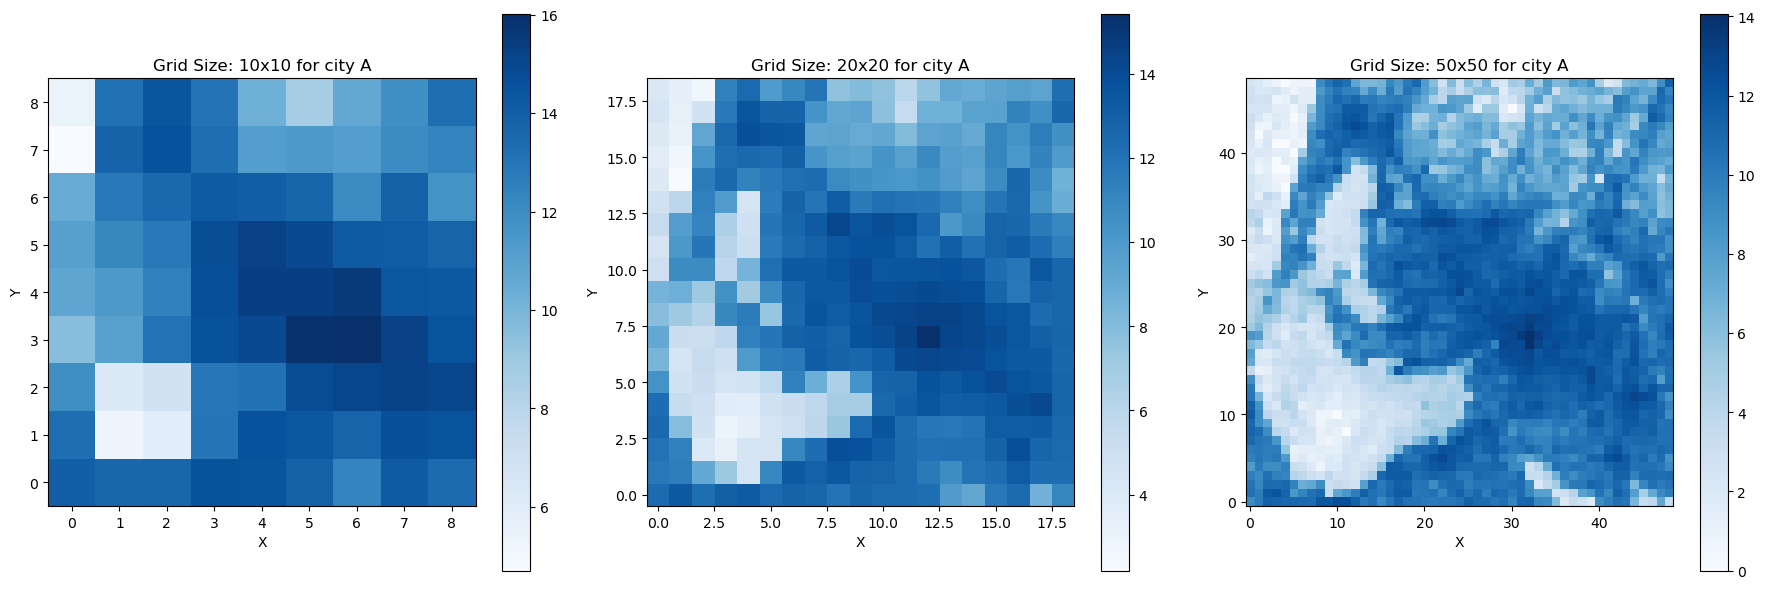

In [144]:
plot_coarse_grained_grid_count(traj_A, 'city A', log= True)

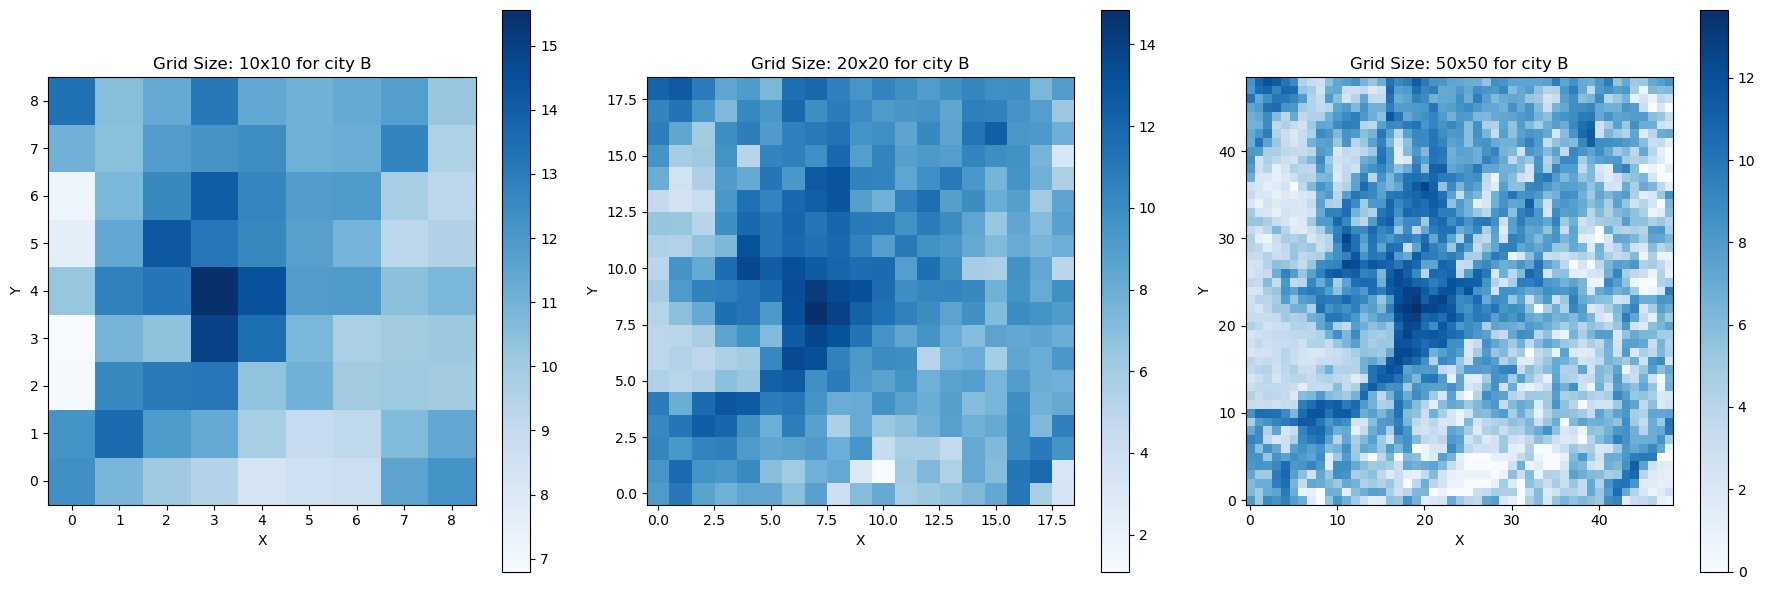

In [146]:
plot_coarse_grained_grid_count(traj_B, 'city B', log=True)

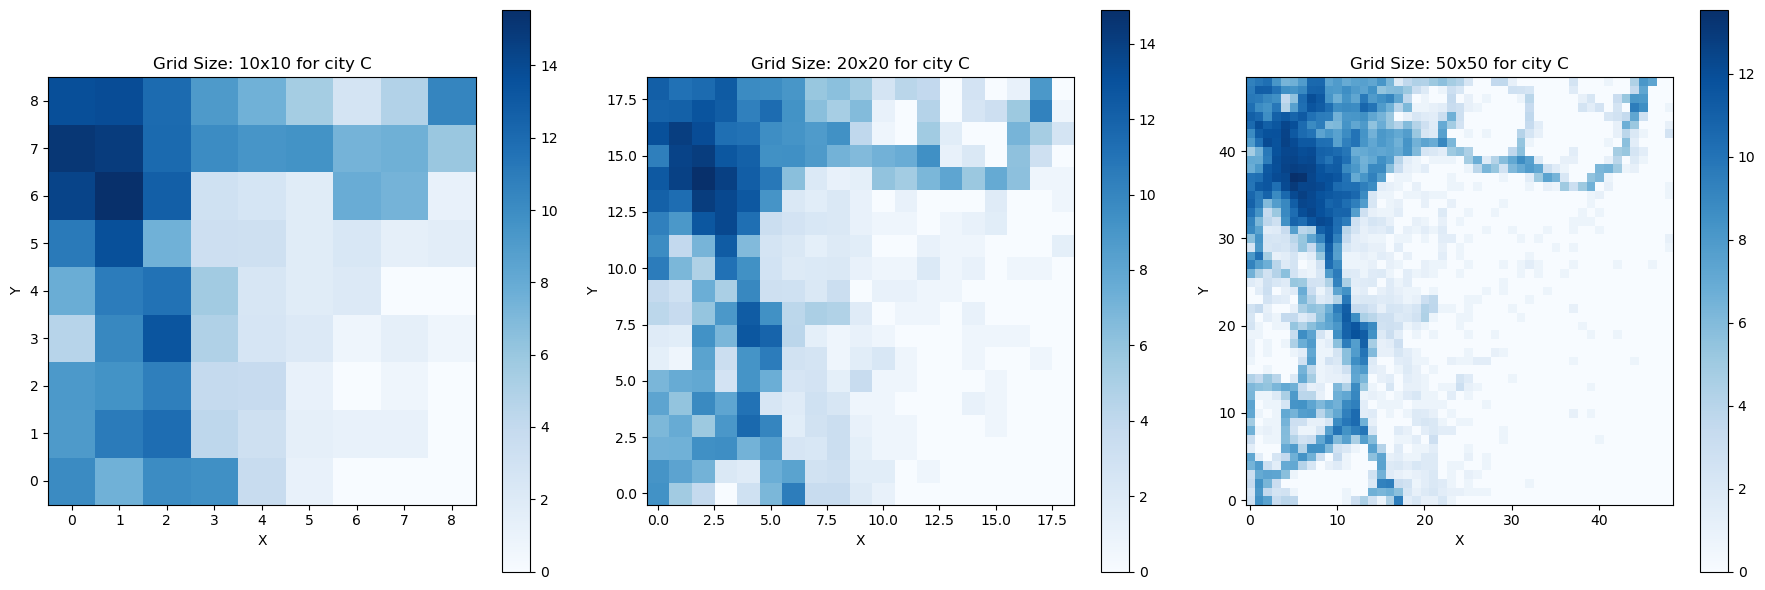

In [147]:
plot_coarse_grained_grid_count(traj_C, 'city C', log=True)

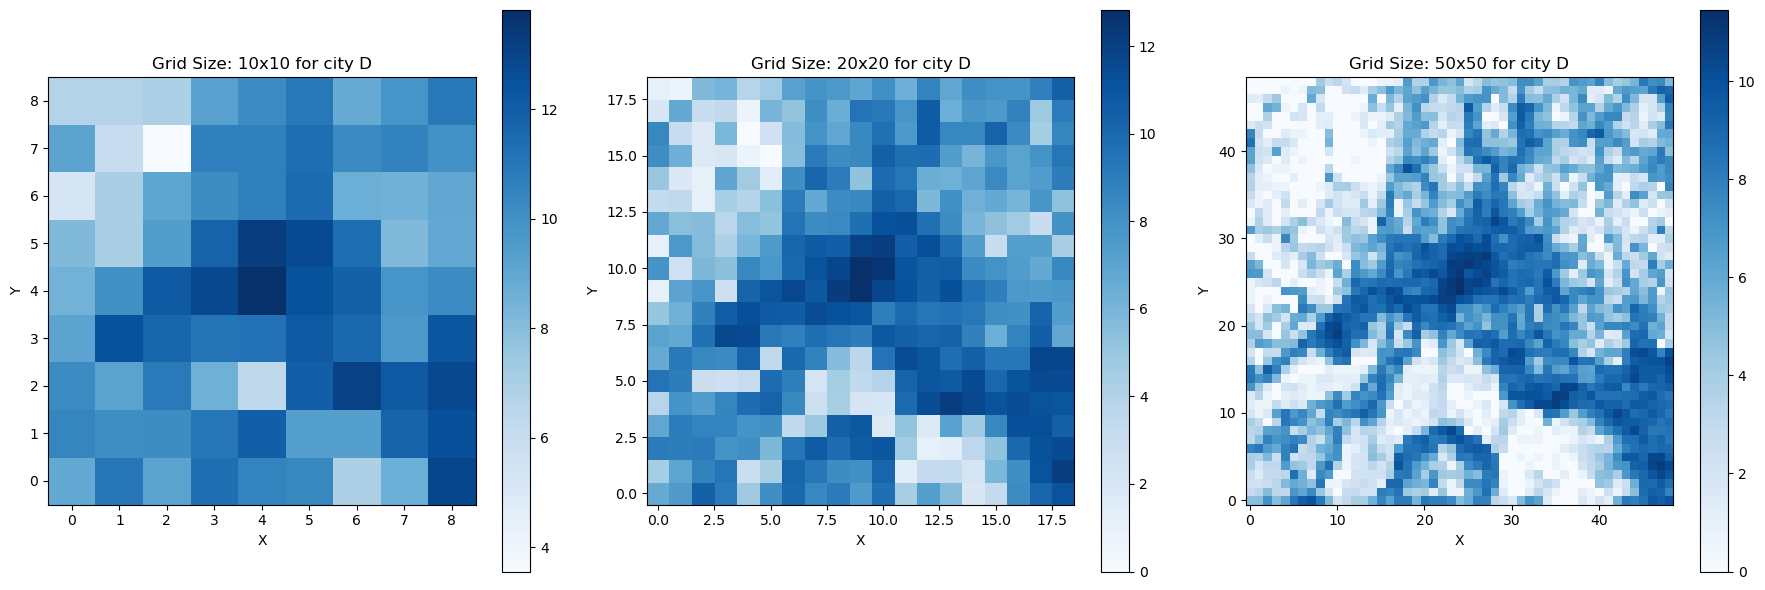

In [148]:
plot_coarse_grained_grid_count(traj_D, 'city D', log=True)